# Practice2. Softmax classifier

In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import _pickle as pickle
import time

# set default plot options
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Data preprocessing

In [2]:
from utils import get_CIFAR10_data

In [3]:
X_tr, Y_tr, X_val, Y_val, X_te, Y_te, mean_img = get_CIFAR10_data()
print ('Train data shape : %s,  Train labels shape : %s' % (X_tr.shape, Y_tr.shape))
print ('Val data shape : %s,  Val labels shape : %s' % (X_val.shape, Y_val.shape))
print ('Test data shape : %s,  Test labels shape : %s' % (X_te.shape, Y_te.shape))

Train data shape : (10000, 3073),  Train labels shape : (10000,)
Val data shape : (1000, 3073),  Val labels shape : (1000,)
Test data shape : (1000, 3073),  Test labels shape : (1000,)


## Visualize training images

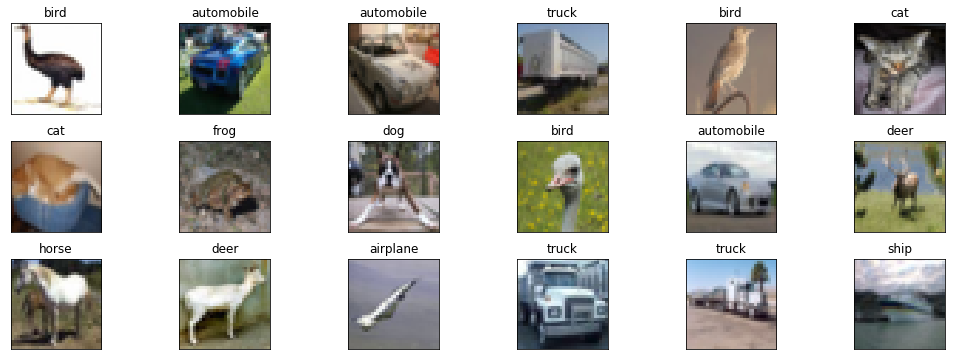

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

images_index = np.int32(np.round(np.random.rand(18,)*10000,0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, idx in zip(axes.flat, images_index):
    img = (X_tr[idx,:3072].reshape(32, 32, 3) + mean_img.reshape(32, 32, 3))/255.
    ax.imshow(img)
    ax.set_title(class_names[Y_tr[idx]])
    

# 1. Softmax Classifier

We will implement two version of loss functions for softmax classifier, and test it out on the CIFAR10 dataset.

First, implement the naive softmax loss function with nested loops.

In [287]:
def naive_softmax_loss(Weights,X_data,Y_data,reg):
    """
     Inputs have D dimension, there are C classes, and we operate on minibatches of N examples.
    
     Inputs :
         - Weights : A numpy array of shape (D,C) containing weights.
         - X_data : A numpy array of shape (N,D) contatining a minibatch of data.
         - Y_data : A numpy array of shape (N,) containing training labels; 
               Y[i]=c means that X[i] has label c, where 0<=c<C.
         - reg : Regularization strength. (float)
         
     Returns :
         - loss as single float
         - gradient with respect to Weights; an array of sample shape as Weights
     """
    
    # Initialize the loss and gradient to zero
    softmax_loss = 0.0
    dWeights = np.zeros_like(Weights)
    #print(dWeights.shape)
    
    ####################################################################################################
    # TODO : Compute the softmax loss and its gradient using explicit loops.                           # 
    #        Store the loss in loss and the gradient in dW.                                            #
    #        If you are not careful here, it is easy to run into numeric instability.                  #
    #        Don't forget the regularization.                                                          #
    #---------------------------------------WRITE YOUR CODE--------------------------------------------#
    #length1 = len(X_data)
    #length2 = len(X_data[0])
    
    traing_times = X_data.shape[0]
    dim,num_class = Weights.shape
    
    print('traing_times',traing_times)
    print('dimen, num_class',dim,num_class)
    for i in range(traing_times):
        
        #Weight Matmul
        score_i = X_data[i].dot(Weights)
        
        #Nomalization(Numeric Stability) - exp 지수값이 너무 커지지 않기 위한
        score_i = score_i - np.max(score_i)
        
        #SoftMax
        prob_i = np.exp(score_i) / np.sum(np.exp(score_i))
        
        #Calculate Loss
        softmax_loss += -np.log(prob_i[Y_data[i]])
        
        #Loss Evaluste
        prob_i[Y_data[i]] -= 1
        dWeights += np.dot(X_data[i].reshape(dim,1),prob_i.reshape(1,num_class))
    
    #Regulazation
    softmax_loss /= traing_times
    softmax_loss += 0.5 * reg * np.sum(Weights*Weights)
    
    #what's this?
    dWeights = (1.0/traing_times)*dWeights + reg*Weights

    #--------------------------------------END OF YOUR CODE--------------------------------------------#
    ####################################################################################################
    return softmax_loss, dWeights

Generate a random softmax weight matrix and use it to compute the loss. As a rough sanity check, our loss should be something close to -log(0.1).

In [288]:
W = np.random.randn(3073, 10) * 0.0001
print(W.shape)
print(W.shape[0] )

(3073, 10)
3073


In [289]:
loss, grad = naive_softmax_loss(W, X_tr, Y_tr, 0.0)

print ('loss :', loss)
print ('sanity check : ', -np.log(0.1))

traing_times 10000
dimen, num_class 3073 10
loss : 2.376243357308479
sanity check :  2.3025850929940455


The next thing is the vectorized softmax loss function.

In [294]:
def vectorized_softmax_loss(Weights, X_data, Y_data, reg):
    softmax_loss = 0.0
    dWeights = np.zeros_like(Weights)

    ####################################################################################################
    # TODO : Compute the softmax loss and its gradient using no explicit loops.                        # 
    #        Store the loss in loss and the gradient in dW.                                            #
    #        If you are not careful here, it is easy to run into numeric instability.                  #
    #        Don't forget the regularization.                                                          #
    #---------------------------------------WRITE YOUR CODE--------------------------------------------#
    
    
    tr_length = X_data.shape[0]
    
    #Weight Matmul
    score = X_data.dot(Weights)
    #print(np.mean(score,axis=0))
    #print(np.mean(score,axis=1))
    
    
    #Nomalization
    score -= np.max(score,axis=1).reshape(tr_length,1)
    
    #SoftMax
    prob = np.exp(score) / np.sum(np.exp(score),axis=1).reshape(tr_length,1)
    
    #Calculate Loss
    softmax_loss = -np.sum(np.log(prob[range(tr_length), Y_data]))
        
    #Loss Evaluste
    prob[range(tr_length), Y_data] -= 1
    
    10000개
    
    dWeights = X_data.T.dot(prob)
    
    #Regularization loss
    softmax_loss /= tr_length
    softmax_loss += 0.5*reg*np.sum(Weights*Weights)
    
    #Regularization 영향
    dWeights = (1.0/tr_length)*dWeights + reg*Weights
    dWeights = dWeights/tr_length  + reg*Weights
    
    
    #--------------------------------------END OF YOUR CODE--------------------------------------------#
    ####################################################################################################
    
    return softmax_loss, dWeights

Compare two versions. The two versions should compute the same results, but the vectorized version should be much faster.

In [295]:
s_time = time.time()
loss_naive, grad_naive = naive_softmax_loss(W, X_tr, Y_tr, 0.00001)
print ('naive loss : %e with %fs' % (loss_naive, time.time()-s_time))

s_time = time.time()
loss_vectorized, grad_vectorized = vectorized_softmax_loss(W, X_tr, Y_tr, 0.00001)
print ('vectorized loss : %e with %fs' % (loss_vectorized, time.time()-s_time))

print ('loss difference : %f' % np.abs(loss_naive - loss_vectorized))
print ('gradient difference : %f' % np.linalg.norm(grad_naive-grad_vectorized, ord='fro'))

traing_times 10000
dimen, num_class 3073 10
naive loss : 2.376243e+00 with 1.403455s
vectorized loss : 2.376243e+00 with 0.149547s
loss difference : 0.000000
gradient difference : 0.000000


In [311]:
rng=np.random.RandomState(123)
ind=range(0,10)
rng.shuffle(ind)


TypeError: 'range' object does not support item assignment

Now, you should implement the softmax classifier using the comment below with softmax loss function you implemented above.

In [346]:
class Softmax(object):
    def __init__(self):
        #self.Weights = None
        return
        
    def train(self, X_tr_data, Y_tr_data, X_val_data, Y_val_data, lr=1e-3, reg=1e-5, iterations=100, bs=128, verbose=False):
        """
        Train this Softmax classifier using stochastic gradient descent.
        
        Inputs have D dimensions, and we operate on N examples.
        
        Inputs :
            - X_data : A numpy array of shape (N,D) containing training data.
            - Y_data : A numpy array of shape (N,) containing training labels;
                  Y[i]=c means that X[i] has label 0<=c<C for C classes.
            - lr : (float) Learning rate for optimization.
            - reg : (float) Regularization strength. 
            - iterations : (integer) Number of steps to take when optimizing. 
            - bs : (integer) Number of training examples to use at each step.
            - verbose : (boolean) If true, print progress during optimization.
        
        Regurns :
            - A list containing the value of the loss function at each training iteration.
        """
        
        num_train, dim = X_tr_data.shape
        num_classes = np.max(Y_tr_data)+1
        self.Weights = 0.001*np.random.randn(dim, num_classes)

            
        for it in range(iterations):
            
            mask = np.random.choice(num_train,bs)
            X_batch, Y_batch = X_tr_data[mask], Y_tr_data[mask]
           
            ####################################################################################################
            # TODO : Sample batch_size elements from the training data and their corresponding labels          #
            #        to use in this round of gradient descent.                                                 #
            #        Store the data in X_batch and their corresponding labels in Y_batch; After sampling       #
            #        X_batch should have shape (dim, batch_size) and Y_batch should have shape (batch_siae,)   #
            #                                                                                                  #
            #        Hint : Use np.random.choice to generate indicies.                                         #
            #               Sampling with replacement is faster than sampling without replacement.             #
            #---------------------------------------WRITE YOUR CODE--------------------------------------------#

            #--------------------------------------END OF YOUR CODE--------------------------------------------#
            ####################################################################################################

            # Evaluate loss and gradient
            tr_loss, tr_grad = self.loss(X_batch, Y_batch, reg)

            # Perform parameter update
            ####################################################################################################
            # TODO : Update the weights using the gradient and the learning rate                               #
            #---------------------------------------WRITE YOUR CODE--------------------------------------------#
            self.Weights += -lr * tr_grad
            #--------------------------------------END OF YOUR CODE--------------------------------------------#
            ####################################################################################################

            if verbose and it % num_iters == 0:
                print ('Ieration %d / %d : loss %f ' % (it, num_iters, loss))
            
        
    
    def predict(self, X_data):
        """
        Use the trained weights of this softmax classifier to predict labels for data points.
        
        Inputs :
            - X : A numpy array of shape (N,D) containing training data.
            
        Returns :
             - Y_pred : Predicted labels for the data in X. Y_pred is a 1-dimensional array of length N, 
                        and each element is an integer giving the predicted class.
        """
        Y_pred = np.zeros(X_data.shape[0])
        
        ####################################################################################################
        # TODO : Implement this method. Store the predicted labels in Y_pred                               #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        
        Y_pred = np.argmax(X_data.dot(self.Weights), axis=1)
        
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        return Y_pred
    
    def get_accuracy(self, X_data, Y_data):
        """
        Use X_data and Y_data to get an accuracy of the model.
        
        Inputs :
            - X_data : A numpy array of shape (N,D) containing input data.
            - Y_data : A numpy array of shape (N,) containing a true label.
            
        Returns :
             - Accuracy : Accuracy of input data pair [X_data, Y_data].
        """
        ####################################################################################################
        # TODO : Implement this method. Calculate an accuracy of X_data using Y_data and predict Func                               #
        #---------------------------------------WRITE YOUR CODE--------------------------------------------#
        Y_pred = self.predict(X_data)
        accuracy = np.mean(Y_pred == Y_data)
        #--------------------------------------END OF YOUR CODE--------------------------------------------#
        ####################################################################################################
        
        return accuracy
    
    def loss(self, X_batch, Y_batch, reg):
        return vectorized_softmax_loss(self.Weights, X_batch, Y_batch, reg)

Use the validatoin set to tune hyperparemeters (regularizatoin strength and learning rate).
You should experiment with different range for the learning rates and regularization strength;
if you are careful you should be able to get a classification accuracy of over 0.35 on the validatoin set.

In [347]:
# results is dictionary mapping tuples of the form.
# (learning_rate, regularization_strength) to tuple of the form (training_accuracy, validation_accuracy).
# The accuracy is simply the fraction of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [5e2, 1e3, 1e4, 5e4]

#########################################################################################################
# TODO : Write code that chooses the best hyperparameters by tuning on the validation set.              # 
#        For each combination of hyperparemeters, train a Softmax on the training set,                  #
#        compute its accuracy on the training and validatoin sets, and store these numbers in the       #
#        results dictionary. In addition, store the best validation accuracy in best_val                #
#        and the Softmax object that achieves this accuracy in best_softmax.                            #
#                                                                                                       #
# Hint : You should use a small value for num_iters as you develop your validation code so that the     #
#        Softmax don't take much time to train; once you are confident that your validation code works, #
#        you should rerun the validation code with a larger value for num_iter.                         #
#------------------------------------------WRITE YOUR CODE----------------------------------------------#
 
for lr in learning_rates:
    for reg in regularization_strengths:
        
        softmax = Softmax()
        softmax.train(X_tr,Y_tr,X_val,Y_val,lr,reg,100)
    
        tr_acc = softmax.get_accuracy(X_tr,Y_tr)
        val_acc = softmax.get_accuracy(X_val,Y_val)
    
        if(val_acc > best_val):
            best_val = val_acc
            best_softmax = softmax
        
        results[(lr,reg)] = (tr_acc, val_acc)
    

#train(self, X_tr_data, Y_tr_data, X_val_data, Y_val_data, lr=1e-3, reg=1e-5, iterations=100, bs=128, verbose=False):
#loss_vectorized, grad_vectorized = vectorized_softmax_loss(W, X_tr, Y_tr, 0.00001)
#softmax.train(X_tr,Y_tr,X_te,Y_te,)

#-----------------------------------------END OF YOUR CODE----------------------------------------------#
#########################################################################################################

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy : %f, val accuracy : %f ' % (lr, reg, train_accuracy, val_accuracy))
    
print ('best validatoin accuracy achieved during cross-validation :', best_val)

lr 1.000000e-08 reg 5.000000e+02 train accuracy : 0.098600, val accuracy : 0.107000 
lr 1.000000e-08 reg 1.000000e+03 train accuracy : 0.103100, val accuracy : 0.118000 
lr 1.000000e-08 reg 1.000000e+04 train accuracy : 0.113700, val accuracy : 0.116000 
lr 1.000000e-08 reg 5.000000e+04 train accuracy : 0.108200, val accuracy : 0.114000 
lr 1.000000e-07 reg 5.000000e+02 train accuracy : 0.134000, val accuracy : 0.127000 
lr 1.000000e-07 reg 1.000000e+03 train accuracy : 0.131700, val accuracy : 0.151000 
lr 1.000000e-07 reg 1.000000e+04 train accuracy : 0.142600, val accuracy : 0.139000 
lr 1.000000e-07 reg 5.000000e+04 train accuracy : 0.150300, val accuracy : 0.164000 
lr 5.000000e-07 reg 5.000000e+02 train accuracy : 0.198600, val accuracy : 0.216000 
lr 5.000000e-07 reg 1.000000e+03 train accuracy : 0.207900, val accuracy : 0.200000 
lr 5.000000e-07 reg 1.000000e+04 train accuracy : 0.215300, val accuracy : 0.212000 
lr 5.000000e-07 reg 5.000000e+04 train accuracy : 0.312600, val a

Evaluate the best softmax on testset.

In [348]:
Y_te_pred = best_softmax.predict(X_te)
test_accuracy = np.mean(Y_te == Y_te_pred)

print ('softmax on raw pixels final test set accuracy : ', test_accuracy)

softmax on raw pixels final test set accuracy :  0.338


## Visualize test results

Visualize (Image, Predicted label) pairs of the best softmax model. Results may are not good because we train simple softmax classifier model.

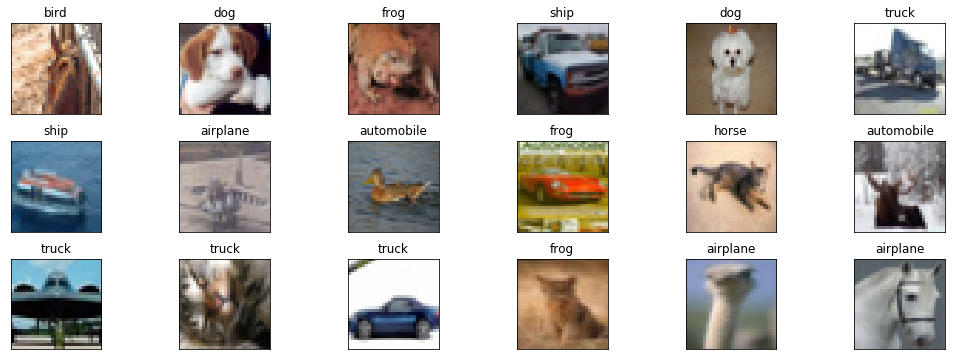

In [349]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

images_index = np.int32(np.round(np.random.rand(18,)*1000,0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, idx in zip(axes.flat, images_index):
    img = (X_te[idx,:3072].reshape(32, 32, 3) + mean_img.reshape(32, 32, 3))/255.
    ax.imshow(img)
    ax.set_title(class_names[Y_te_pred[idx]])
    

## Visualize test results

Visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

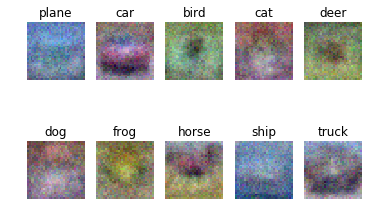

In [350]:
w = best_softmax.Weights[:-1, :]
w = w.reshape(32,32,3,10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2,5,i+1)
    
    wimg=255.0*(w[:,:,:,i].squeeze() - w_min)/(w_max-w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])